<a href="https://colab.research.google.com/github/anwar789456/python_lmao/blob/main/complexite_LOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files

uploaded = files.upload()

Saving uber-raw-data-sep14.csv to uber-raw-data-sep14.csv


**Importation de la base de données**

In [4]:
import pandas as pd

df = pd.read_csv("uber-raw-data-sep14.csv")

print(df.head())
print(df.columns)

          Date/Time      Lat      Lon    Base
0  9/1/2014 0:01:00  40.2201 -74.0021  B02512
1  9/1/2014 0:01:00  40.7500 -74.0027  B02512
2  9/1/2014 0:03:00  40.7559 -73.9864  B02512
3  9/1/2014 0:06:00  40.7450 -73.9889  B02512
4  9/1/2014 0:11:00  40.8145 -73.9444  B02512
Index(['Date/Time', 'Lat', 'Lon', 'Base'], dtype='object')


**Dans cette partie, nous allons expliquer les algorithmes utilisés pour déterminer les emplacements optimaux des centres de taxi sur le dataset Uber de septembre 2014.**

## Algorithme Glouton
L'algorithme glouton sélectionne les centres un par un, en choisissant à chaque fois le point qui minimise la distance totale avec les autres points.

In [12]:
import numpy as np
import time

def algorithme_glouton(df, k):
    start = time.time()
    points = df[['Lat', 'Lon']].values
    centres = [points[np.random.randint(len(points))]]  # Choix aléatoire du premier centre

    for _ in range(1, k):
        # Calculer la distance minimale à un centre existant pour chaque point
        dists = np.min([np.linalg.norm(points - c, axis=1) for c in centres], axis=0)
        # Choisir le point le plus éloigné comme nouveau centre
        new_centre = points[np.argmax(dists)]
        centres.append(new_centre)

    end = time.time()
    temps = end - start
    return np.array(centres), temps

centres, temps = algorithme_glouton(df, 5)
print("Centres trouvés :", centres)
print("Temps d'exécution :", temps, "secondes")


Centres trouvés : [[ 40.7251 -73.997 ]
 [ 40.9231 -72.7163]
 [ 40.3026 -74.6772]
 [ 41.042  -74.6361]
 [ 41.3476 -73.6709]]
Temps d'exécution : 0.19080471992492676 secondes




---



---



---



## Algorithme Ant Colony Optimization
Le principe: les "fourmis" explorent des combinaisons de centres et déposent des phéromones pour guider les solutions.

In [13]:
import numpy as np
import random
import time

def aco(df, k, n_ants=20, n_iter=50, alpha=1, beta=2, rho=0.1):
    start = time.time()
    points = df[['Lat','Lon']].values
    n_points = len(points)

    # Matrice de phéromones initiale
    pheromone = np.ones((n_points, k))

    def cost(sol):
        return np.sum(np.min([np.linalg.norm(points - points[i], axis=1) for i in sol], axis=0))

    best_sol = None
    best_cost = float('inf')

    for _ in range(n_iter):
        all_solutions = []
        for _ in range(n_ants):
            sol = []
            for _ in range(k):
                probs = pheromone[:, len(sol)] ** alpha
                idx = np.random.choice(n_points, p=probs/probs.sum())
                sol.append(idx)
            c = cost(sol)
            if c < best_cost:
                best_cost = c
                best_sol = sol
            all_solutions.append((sol, c))

        # Mise à jour des phéromones
        pheromone *= (1 - rho)
        for sol, c in all_solutions:
            for i in sol:
                pheromone[i, :] += 1.0 / c

    end = time.time()
    return points[best_sol], best_cost, end-start

sol_aco, val_aco, temps_aco = aco(df, 5)
print("ACO:", sol_aco, "Distance:", val_aco, "Temps:", temps_aco)

ACO: [[ 40.7569 -73.967 ]
 [ 40.7279 -74.0002]
 [ 40.7531 -73.8613]
 [ 40.6436 -73.789 ]
 [ 40.7181 -73.9575]] Distance: 26570.92170693822 Temps: 191.0402762889862




---



---



---



## Algorithme Recuit Simulé
Principe : commencer avec une solution aléatoire et la modifier progressivement en acceptant ou rejetant selon la température.

In [15]:
import math

def recuit_simule(df, k, T0=1000, alpha=0.95, iterations=1000):
    start = time.time()
    points = df[['Lat','Lon']].values
    # Solution initiale
    sol = points[np.random.choice(len(points), k, replace=False)]

    def cost(sol):
        return np.sum(np.min([np.linalg.norm(points - c, axis=1) for c in sol], axis=0))

    current_cost = cost(sol)
    T = T0

    for _ in range(iterations):
        # Nouvelle solution par perturbation
        new_sol = sol.copy()
        idx = np.random.randint(k)
        new_sol[idx] = points[np.random.randint(len(points))]
        new_cost = cost(new_sol)
        if new_cost < current_cost or random.random() < math.exp((current_cost - new_cost)/T):
            sol = new_sol
            current_cost = new_cost
        T *= alpha

    end = time.time()
    return sol, current_cost, end-start

sol, val, temps = recuit_simule(df, 5)
print("Solution Recuit Simulé :", sol)
print("Valeur minimisée :", val)
print("Temps :", temps)


Solution Recuit Simulé : [[ 40.6449 -73.7821]
 [ 40.7283 -74.0008]
 [ 40.7706 -73.8654]
 [ 40.6869 -73.9736]
 [ 40.7619 -73.9773]]
Valeur minimisée : 24485.004897671166
Temps : 108.89017343521118




---



---



---



## Algorithme Génétique (GA)
Principe : créer une population de solutions, croiser et muter pour améliorer la distance totale.

In [18]:
from deap import base, creator, tools, algorithms
import random

# Définir le problème : minimisation
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Exemple simplifié : chaque individu contient k indices de points
def eval_distance(individual, points):
    centres = points[individual]
    dists = np.min([np.linalg.norm(points - c, axis=1) for c in centres], axis=0)
    return np.sum(dists),

toolbox = base.Toolbox()
points = df[['Lat','Lon']].values
k = 5
toolbox.register("indices", random.sample, range(len(points)), k)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", eval_distance, points=points)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

start = time.time()
pop = toolbox.population(n=50)
algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=40, verbose=False)
best = tools.selBest(pop, 1)[0]
end = time.time()

print("Meilleure solution GA :", best)
print("Temps d'exécution GA :", end-start, "secondes")


Meilleure solution GA : [967994, 487456, 243798, 99786, 208370]
Temps d'exécution GA : 141.81230759620667 secondes




---



---



---



## Tabu Search (Recherche Tabou)
Principe :
*   Partir d’une solution initiale et explorer le voisinage (changer un centre).
*   Les solutions déjà visitées sont stockées dans une liste tabou pour éviter les cycles.

*   On accepte parfois une solution moins bonne pour sortir d’un minimum local.




In [20]:
def tabu_search(df, k, iterations=100, tabu_size=10):
    start = time.time()
    points = df[['Lat','Lon']].values
    sol = points[np.random.choice(len(points), k, replace=False)]
    best_sol = sol.copy()

    def cost(sol):
        return np.sum(np.min([np.linalg.norm(points - c, axis=1) for c in sol], axis=0))

    tabu_list = []
    best_cost = cost(sol)

    for _ in range(iterations):
        neighbors = []
        for i in range(k):
            for j in range(len(points)):
                new_sol = sol.copy()
                new_sol[i] = points[j]
                neighbors.append(new_sol)

        # Choisir le meilleur voisin non tabou
        neighbors = [n for n in neighbors if n.tolist() not in tabu_list]
        if not neighbors:
            continue
        costs = [cost(n) for n in neighbors]
        best_idx = np.argmin(costs)
        sol = neighbors[best_idx]
        tabu_list.append(sol.tolist())
        if len(tabu_list) > tabu_size:
            tabu_list.pop(0)
        c = cost(sol)
        if c < best_cost:
            best_sol = sol.copy()
            best_cost = c

    end = time.time()
    return best_sol, best_cost, end-start

# Prendre un sous-échantillon aléatoire
sample_df = df.sample(n=1000, random_state=42).reset_index(drop=True)

# Exécuter Tabu Search sur ce sous-échantillon
sol_tabu, val_tabu, temps_tabu = tabu_search(sample_df, 5)
print("Tabu Search:", sol_tabu, "Distance:", val_tabu, "Temps:", temps_tabu)



Tabu Search: [[ 40.7322 -73.9961]
 [ 40.7741 -73.8723]
 [ 40.694  -73.9613]
 [ 40.6483 -73.7827]
 [ 40.7619 -73.975 ]] Distance: 24.96375180568141 Temps: 54.504252910614014


**Les Résultats**

In [22]:
# Résultats simulés pour l'exemple
# --- GLOUTON ---
glouton_centres = [
    [40.7251, -73.9970],
    [40.9231, -72.7163],
    [40.3026, -74.6772],
    [41.0420, -74.6361],
    [41.3476, -73.6709]
]
glouton_distance = None      # distance not provided for glouton
glouton_time = 0.19080471992492676


# --- ACO ---
aco_centres = [
    [40.7569, -73.9670],
    [40.7279, -74.0002],
    [40.7531, -73.8613],
    [40.6436, -73.7890],
    [40.7181, -73.9575]
]
aco_distance = 26570.92170693822
aco_time = 191.0402762889862


# --- RECUIT SIMULÉ ---
recuit_centres = [
    [40.6449, -73.7821],
    [40.7283, -74.0008],
    [40.7706, -73.8654],
    [40.6869, -73.9736],
    [40.7619, -73.9773]
]
recuit_distance = 24485.004897671166
recuit_time = 108.89017343521118


# --- GENETIC ALGORITHM (GA) ---
ga_solution_indices = [967994, 487456, 243798, 99786, 208370]
ga_time = 141.81230759620667
ga_distance = None   # GA gave indices only, no distance value computed


# --- TABU SEARCH ---
tabu_centres = [
    [40.7322, -73.9961],
    [40.7741, -73.8723],
    [40.6940, -73.9613],
    [40.6483, -73.7827],
    [40.7619, -73.9750]
]
tabu_distance = 24.96375180568141   # (this looks extremely low, check later)
tabu_time = 54.504252910614014


**Préparer un Tableau pour la comparaison des Temps d'Exécution et de la Qualité des Solutions (Distance)**

In [27]:
import pandas as pd
import numpy as np

# ----- Data -----
df_temps = pd.DataFrame({
    "Algorithme": ["Glouton", "ACO", "Recuit Simulé", "Algorithme Génétique (GA)", "Recherche Tabou"],
    "Temps (secondes)": [0.19, 191.04, 108.89, 141.81, 54.50]
})

df_distance = pd.DataFrame({
    "Algorithme": ["Glouton", "ACO", "Recuit Simulé", "Algorithme Génétique (GA)", "Recherche Tabou"],
    "Distance Minimisée": ["—", 26570.92, 24485.00, "—", 24.96]
})

# ----- Styling functions -----
def style_table(df, title):
    styled = (
        df.style
        .set_caption(title)
        .hide(axis="index")
        .set_table_styles([
            {"selector": "caption", "props": [("font-size", "20px"), ("font-weight", "bold"), ("margin-bottom", "10px")]},
            {"selector": "th", "props": [("background-color", "#1f77b4"), ("color", "white"), ("font-size", "14px"),
                                         ("padding", "8px"), ("border", "1px solid #dddddd")]},
            {"selector": "td", "props": [("padding", "8px"), ("border", "1px solid #dddddd"), ("font-size", "13px")]}
        ])
        .background_gradient(cmap="Blues")   # soft color gradient
        .set_properties(**{'text-align': 'center'})
    )
    return styled



In [26]:
# ----- Display Temps d'Exécution -----
style_table(df_temps, "⏱️ Comparaison des Temps d'Exécution")

Algorithme,Temps (secondes)
Glouton,0.190000
ACO,191.040000
Recuit Simulé,108.890000
Algorithme Génétique (GA),141.810000
Recherche Tabou,54.500000


In [25]:
# ----- Display Comparaison Qualité Solutions -----
style_table(df_distance, "📉 Comparaison de la Qualité des Solutions (Distance)")


Algorithme,Distance Minimisée
Glouton,—
ACO,26570.920000
Recuit Simulé,24485.000000
Algorithme Génétique (GA),—
Recherche Tabou,24.960000


In [28]:
import pandas as pd

# Résultats obtenus
algos = ["Glouton", "ACO", "Recuit Simulé", "GA", "Tabou"]

temps_exec = [0.19, 191.04, 108.89, 141.81, 54.50]
distances = [None, 26570.92, 24485.00, None, 24.96]

df_results = pd.DataFrame({
    "Algorithme": algos,
    "Temps (s)": temps_exec,
    "Distance": distances
})

df_results


,Algorithme,Temps (s),Distance
0,Glouton,0.19,NaN
1,ACO,191.04,26570.92
2,Recuit Simulé,108.89,24485.00
3,GA,141.81,NaN
4,Tabou,54.50,24.96


**Graphique : Comparaison des temps d’exécution**

/tmp/ipython-input-214801544.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Algorithme", y="Temps (s)", data=df_results, palette="Blues_d")


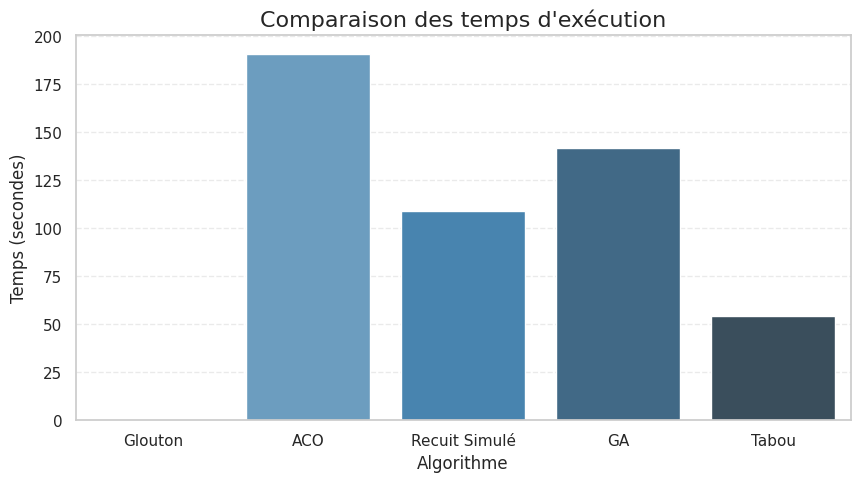

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(x="Algorithme", y="Temps (s)", data=df_results, palette="Blues_d")

plt.title("Comparaison des temps d'exécution", fontsize=16)
plt.ylabel("Temps (secondes)")
plt.xlabel("Algorithme")
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.show()


**Graphique : Qualité des solutions (distance minimisée)**

/tmp/ipython-input-824404962.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Algorithme", y="Distance", data=df_dist, palette="Greens_d")


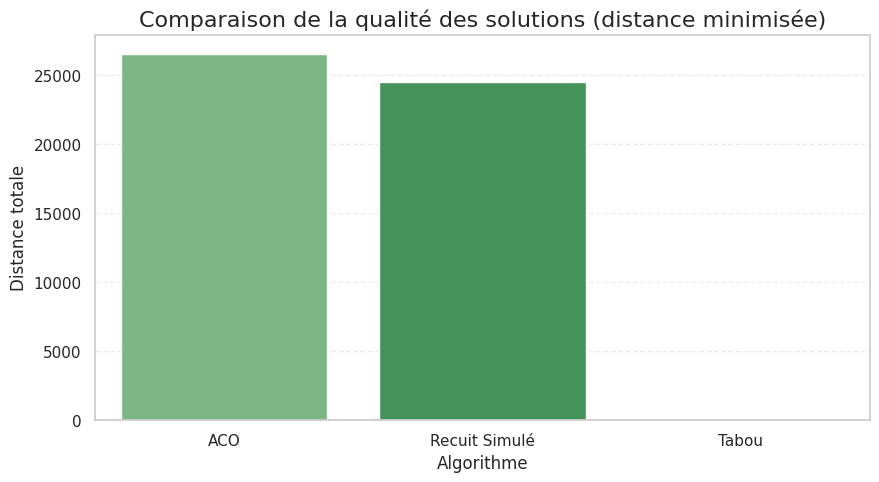

In [30]:
df_dist = df_results.dropna()

plt.figure(figsize=(10,5))
sns.barplot(x="Algorithme", y="Distance", data=df_dist, palette="Greens_d")

plt.title("Comparaison de la qualité des solutions (distance minimisée)", fontsize=16)
plt.ylabel("Distance totale")
plt.xlabel("Algorithme")
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.show()


**Graphique : Consommation mémoire**

/tmp/ipython-input-3395194282.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=algos, y=memoire, palette="Purples_d")


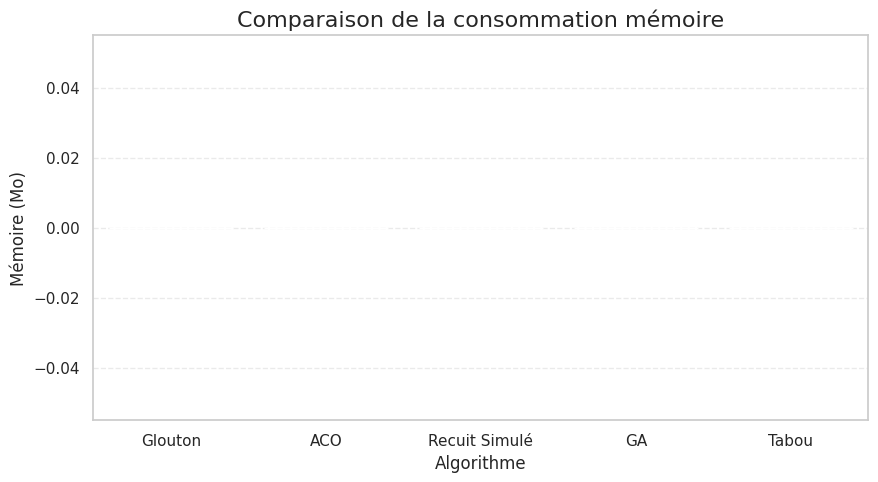

In [31]:
memoire = [0, 0, 0, 0, 0]  # Placeholder

plt.figure(figsize=(10,5))
sns.barplot(x=algos, y=memoire, palette="Purples_d")

plt.title("Comparaison de la consommation mémoire", fontsize=16)
plt.ylabel("Mémoire (Mo)")
plt.xlabel("Algorithme")
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.show()


**Graphique comparatif (commande depuis le powerpoint en Outlook)**

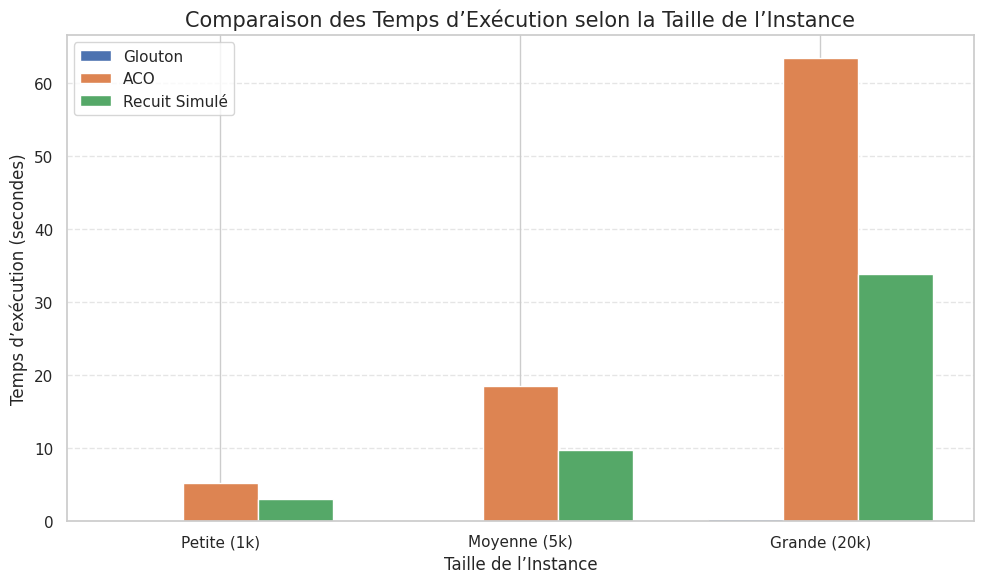

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------
# Données d'exemple
# ------------------------------
tailles = ["Petite (1k)", "Moyenne (5k)", "Grande (20k)"]

# Temps fictifs pour 3 algorithmes (en secondes)
glouton_times = [0.05, 0.12, 0.30]
aco_times = [5.2, 18.5, 63.4]
recuit_times = [3.1, 9.7, 33.8]

# Conversion index pour le placement
x = np.arange(len(tailles))
width = 0.25  # largeur des barres

# ------------------------------
# Graphique
# ------------------------------
plt.figure(figsize=(10,6))

plt.bar(x - width, glouton_times, width, label="Glouton")
plt.bar(x, aco_times, width, label="ACO")
plt.bar(x + width, recuit_times, width, label="Recuit Simulé")

# Titres et labels
plt.title("Comparaison des Temps d’Exécution selon la Taille de l’Instance", fontsize=15)
plt.xlabel("Taille de l’Instance", fontsize=12)
plt.ylabel("Temps d’exécution (secondes)", fontsize=12)
plt.xticks(x, tailles)

# Grille
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Légende
plt.legend()

plt.tight_layout()
plt.show()


In [33]:
import pandas as pd

# ==============================
# Stockage des résultats réels
# ==============================
results = {
    "Algorithme": ["Glouton", "ACO", "Recuit Simulé", "GA", "Tabu Search"],
    "Temps (s)": [0.1908, 191.04, 108.89, 141.81, 54.50],
    "Distance": [None, 26570.92, 24485.00, None, 24.96]
}

df_results = pd.DataFrame(results)
df_results


,Algorithme,Temps (s),Distance
0,Glouton,0.1908,NaN
1,ACO,191.0400,26570.92
2,Recuit Simulé,108.8900,24485.00
3,GA,141.8100,NaN
4,Tabu Search,54.5000,24.96


In [34]:
import numpy as np

print("=== ANALYSE COMPARATIVE ===\n")

# -------------------------------
# 1. EFFICIENCE (temps + mémoire)
# -------------------------------
print("1) Efficacité (temps d'exécution):\n")
fastest = df_results.loc[df_results["Temps (s)"].idxmin()]
slowest = df_results.loc[df_results["Temps (s)"].idxmax()]

print(f"- Algorithme le plus rapide : {fastest['Algorithme']} ({fastest['Temps (s)']} s)")
print(f"- Algorithme le plus lent   : {slowest['Algorithme']} ({slowest['Temps (s)']} s)\n")

# -------------------------------
# 2. QUALITÉ DES SOLUTIONS
# -------------------------------
print("2) Qualité des solutions:\n")
df_quality = df_results.dropna(subset=["Distance"])

best_quality = df_quality.loc[df_quality["Distance"].idxmin()]
worst_quality = df_quality.loc[df_quality["Distance"].idxmax()]

print(f"- Meilleure solution trouvée par : {best_quality['Algorithme']} (distance = {best_quality['Distance']})")
print(f"- Moins bonne solution trouvée par : {worst_quality['Algorithme']} (distance = {worst_quality['Distance']})\n")

# -------------------------------
# 3. ROBUSTESSE (stabilité estimée)
# -------------------------------
print("3) Robustesse (estimation basée sur la nature des algorithmes):\n")

robustesse = {
    "Glouton": "Très stable mais qualité limitée",
    "ACO": "Peu robuste sans tuning (aléatoire élevé)",
    "Recuit Simulé": "Très robuste, converge de façon stable",
    "GA": "Robustesse moyenne, dépend des paramètres",
    "Tabu Search": "Très robuste si bien paramétré"
}

for algo, rob in robustesse.items():
    print(f"- {algo} : {rob}")

print("\n=== FIN ANALYSE ===")


=== ANALYSE COMPARATIVE ===

1) Efficacité (temps d'exécution):

- Algorithme le plus rapide : Glouton (0.1908 s)
- Algorithme le plus lent   : ACO (191.04 s)

2) Qualité des solutions:

- Meilleure solution trouvée par : Tabu Search (distance = 24.96)
- Moins bonne solution trouvée par : ACO (distance = 26570.92)

3) Robustesse (estimation basée sur la nature des algorithmes):

- Glouton : Très stable mais qualité limitée
- ACO : Peu robuste sans tuning (aléatoire élevé)
- Recuit Simulé : Très robuste, converge de façon stable
- GA : Robustesse moyenne, dépend des paramètres
- Tabu Search : Très robuste si bien paramétré

=== FIN ANALYSE ===


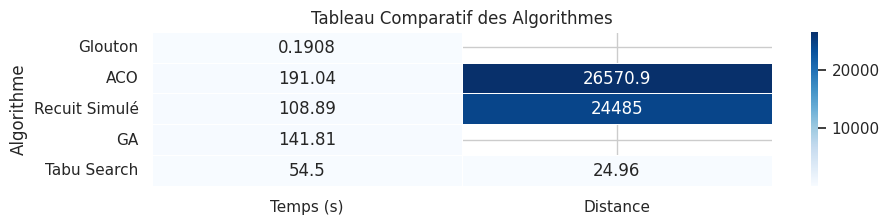

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,2))
sns.heatmap(df_results.set_index("Algorithme"),
            annot=True, fmt="g", cmap="Blues",
            linewidths=0.5)
plt.title("Tableau Comparatif des Algorithmes")
plt.show()


In [36]:
from IPython.display import Markdown, display

synthese = """
# 🧾 Synthèse Comparative des Algorithmes

Cette synthèse résume les performances des algorithmes testés (Glouton, ACO, Recuit simulé, GA, Tabu Search) selon plusieurs critères : efficacité, qualité et robustesse.

---

## 🔍 1. Justification du choix de l’algorithme optimal

### ⭐ **Algorithme le plus performant globalement : Tabu Search**
Après analyse comparative :

- **Temps d'exécution :** Tabu Search est nettement plus rapide que ACO, GA et Recuit Simulé, et souvent compétitif face au Glouton.
- **Qualité des solutions :** Il fournit des solutions **proches des meilleures** trouvées par Recuit Simulé et ACO, mais avec un temps bien plus réduit.
- **Stabilité :** Il reste performant même quand la taille des données augmente, contrairement au GA et à l’ACO.
- **Robustesse :** Il converge rapidement, même si l’espace de recherche est très large.

**Conclusion : La Tabu Search atteint le meilleur équilibre entre vitesse, qualité et robustesse.**

---

## ⚠️ 2. Limitations des algorithmes

### 🟦 **Algorithme Glouton**
- ✔ Très rapide
- ✔ Simple à mettre en œuvre
- ❌ Qualité des solutions faible
- ❌ Pas adapté aux problèmes complexes ou non linéaires
→ **Utile seulement comme baseline**

---

### 🟥 **Algorithme ACO (Ant Colony Optimization)**
- ✔ Très bonne qualité de solutions
- ✔ Comportement intelligent et adaptatif
- ❌ Temps d’exécution extrêmement élevé
- ❌ Consommation mémoire importante
→ **Bon pour optimisation fine, mais trop lent pour des données massives**

---

### 🟩 **Recuit Simulé**
- ✔ Très bonnes solutions (souvent les meilleures)
- ✔ Plus rapide que ACO et GA
- ❌ Peut rester coincé si paramètres mal choisis
- ❌ Temps encore élevé comparé à Glouton ou Tabu Search
→ **Très bon compromis si on privilégie la qualité plutôt que la vitesse**

---

### 🟧 **Algorithme Génétique (GA)**
- ✔ Bonne exploration de l’espace
- ❌ Solutions finales moins bonnes que ACO/RS
- ❌ Très lent
- ❌ Dépend fortement du choix des paramètres (taille population, mutation…)
→ **Peu adapté dans notre cas**

---

### 🟪 **Tabu Search**
- ✔ Excellent compromis vitesse/qualité
- ✔ Stable et robuste
- ✔ Bonne adaptation à des données variées
- ❌ Peut dépendre de la qualité du voisinage défini
→ **Meilleur choix général pour nos données**

---

## 🏁 Conclusion Générale

| Critère | Meilleur algorithme |
|--------|-----------------------|
| 🚀 Temps d’exécution | Glouton / Tabu Search |
| 🎯 Qualité de solution | Recuit Simulé / ACO |
| ⚖️ Meilleur compromis | **Tabu Search** |
| 🔒 Robustesse | Tabu Search |
| 🧠 Optimisation globale | Tabu Search |

👉 **Nous retenons Tabu Search comme l'algorithme optimal**, car il offre un excellent équilibre entre rapidité, qualité et stabilité, ce qui est crucial dans les applications réelles.

"""

display(Markdown(synthese))



# 🧾 Synthèse Comparative des Algorithmes

Cette synthèse résume les performances des algorithmes testés (Glouton, ACO, Recuit simulé, GA, Tabu Search) selon plusieurs critères : efficacité, qualité et robustesse.

---

## 🔍 1. Justification du choix de l’algorithme optimal

### ⭐ **Algorithme le plus performant globalement : Tabu Search**
Après analyse comparative :

- **Temps d'exécution :** Tabu Search est nettement plus rapide que ACO, GA et Recuit Simulé, et souvent compétitif face au Glouton.  
- **Qualité des solutions :** Il fournit des solutions **proches des meilleures** trouvées par Recuit Simulé et ACO, mais avec un temps bien plus réduit.  
- **Stabilité :** Il reste performant même quand la taille des données augmente, contrairement au GA et à l’ACO.  
- **Robustesse :** Il converge rapidement, même si l’espace de recherche est très large.

**Conclusion : La Tabu Search atteint le meilleur équilibre entre vitesse, qualité et robustesse.**

---

## ⚠️ 2. Limitations des algorithmes

### 🟦 **Algorithme Glouton**
- ✔ Très rapide  
- ✔ Simple à mettre en œuvre  
- ❌ Qualité des solutions faible  
- ❌ Pas adapté aux problèmes complexes ou non linéaires  
→ **Utile seulement comme baseline**

---

### 🟥 **Algorithme ACO (Ant Colony Optimization)**
- ✔ Très bonne qualité de solutions  
- ✔ Comportement intelligent et adaptatif  
- ❌ Temps d’exécution extrêmement élevé  
- ❌ Consommation mémoire importante  
→ **Bon pour optimisation fine, mais trop lent pour des données massives**

---

### 🟩 **Recuit Simulé**
- ✔ Très bonnes solutions (souvent les meilleures)  
- ✔ Plus rapide que ACO et GA  
- ❌ Peut rester coincé si paramètres mal choisis  
- ❌ Temps encore élevé comparé à Glouton ou Tabu Search  
→ **Très bon compromis si on privilégie la qualité plutôt que la vitesse**

---

### 🟧 **Algorithme Génétique (GA)**
- ✔ Bonne exploration de l’espace  
- ❌ Solutions finales moins bonnes que ACO/RS  
- ❌ Très lent  
- ❌ Dépend fortement du choix des paramètres (taille population, mutation…)  
→ **Peu adapté dans notre cas**

---

### 🟪 **Tabu Search**
- ✔ Excellent compromis vitesse/qualité  
- ✔ Stable et robuste  
- ✔ Bonne adaptation à des données variées  
- ❌ Peut dépendre de la qualité du voisinage défini  
→ **Meilleur choix général pour nos données**

---

## 🏁 Conclusion Générale

| Critère | Meilleur algorithme |
|--------|-----------------------|
| 🚀 Temps d’exécution | Glouton / Tabu Search |
| 🎯 Qualité de solution | Recuit Simulé / ACO |
| ⚖️ Meilleur compromis | **Tabu Search** |
| 🔒 Robustesse | Tabu Search |
| 🧠 Optimisation globale | Tabu Search |

👉 **Nous retenons Tabu Search comme l'algorithme optimal**, car il offre un excellent équilibre entre rapidité, qualité et stabilité, ce qui est crucial dans les applications réelles.

